In [26]:
import pandas as pd
import random
import networkx as nx
import glob
import os
import seaborn as sns

In [2]:
##  Define paths for data files

working_dir = "/sfs/gpfs/tardis/project/bii_nssac/people/bl4zc/pgcoe_genepi_analytics"
ll_file = f"{working_dir}/data/initial_linelist.csv.xz"

general_population_path = '/project/bii_nssac/production/detailed_populations/ver_2_4_0/'
population_path = '/project/bii_nssac/production/detailed_populations/ver_2_4_0/va'

In [ ]:
df = pd.read_csv(ll_file,compression='xz')
df.sample(5)

,virus,region,country,division,divisionExposure,date,strain,sim_pid,contact_pid,sim_tick,...,vehicles,hh_income,household_language,family_type_and_employment_status,workers_in_family,rlid,asymptomatic,test_prob,tested_positive,exit_state
421006,ncov,North America,USA,Virginia,Virginia,2021-08-09,NaN,365558770,365558772,252,...,2,22000,4,4.0,0.0,1123737585,False,0.13500,1,I2_a
1232139,ncov,North America,USA,Virginia,Virginia,2021-11-15,NaN,363335493,363280784,350,...,3,158600,4,1.0,2.0,1124687271,False,0.63000,1,I2_a
236968,ncov,North America,USA,Virginia,Virginia,2021-07-30,NaN,363151798,363151796,242,...,4,516000,1,1.0,3.0,1124721478,False,1.00000,1,I2_s
242392,ncov,North America,USA,Virginia,Virginia,2021-07-30,NaN,365330230,365429920,242,...,2,165300,1,1.0,2.0,1122181694,False,0.63000,1,I2_a
1650,ncov,North America,USA,Virginia,Virginia,2021-06-06,NaN,366153710,366153711,188,...,1,21400,1,8.0,1.0,1123786448,False,0.29025,1,I2_s
260379,ncov,North America,USA,Virginia,Virginia,2021-07-31,NaN,365583534,365583535,243,...,2,230900,1,2.0,1.0,1123188654,False,0.63000,1,I2_a
378191,ncov,North America,USA,Virginia,Virginia,2021-08-07,NaN,363408150,363409161,250,...,3,205000,1,1.0,2.0,1122199689,False,1.00000,1,I2_s


## Read in the Population level social network
Population file reading takes ~50s network construction takes a long time!

In [4]:
###  A very quick sample for revealing the structure
net_df = pd.read_parquet(f"{population_path}/population_network/daily/network-0/contacts-999.parquet")
net_df.sample(5)

,pid1,pid2,day_number,lid,slid,start_time,duration,activity1,activity2
50139,368101818,368101814,2,1124735104,-1,254100,19500,1,1
26134,367655258,366596945,2,8782762,-1,214800,420,4,2
44547,363057016,363057020,2,1123368819,-1,225300,3300,4,1
2174,362292140,362323388,2,974070,-1,205500,6000,4,2
36296,365035446,365035373,2,11774946,-1,202500,24900,5,5


In [5]:
# Get all parquet files in the folder
parquet_folder = f"{population_path}/population_network/daily/network-0/"
parquet_files = sorted(glob.glob(os.path.join(parquet_folder, "contacts-*.parquet")))

# Read and concatenate all parquet files
all_dfs = []
for file in parquet_files:
    df_temp = pd.read_parquet(file)
    all_dfs.append(df_temp)

# Concatenate all dataframes
combined_net_df = pd.concat(all_dfs, ignore_index=True)
print(f"Loaded {len(parquet_files)} parquet files")
print(f"Combined dataframe shape: {combined_net_df.shape}")
print(f"Columns: {combined_net_df.columns.tolist()}")

Loaded 1480 parquet files
Combined dataframe shape: (99240447, 9)
Columns: ['pid1', 'pid2', 'day_number', 'lid', 'slid', 'start_time', 'duration', 'activity1', 'activity2']


In [6]:
# Create a directed graph from the contact network using from_pandas_edgelist (more efficient)
source_col = combined_net_df.columns[0]
target_col = combined_net_df.columns[1]

pop_G = nx.from_pandas_edgelist(
    combined_net_df,
    source=source_col,
    target=target_col,
    edge_attr=['duration', 'lid','activity1'],
    create_using=nx.DiGraph()
)

print(f"Graph created with {pop_G.number_of_nodes()} nodes and {pop_G.number_of_edges()} edges")

Graph created with 7605731 nodes and 88880744 edges


In [7]:
def get_shortest_path_with_edge_attributes(G, pid1, pid2, net_type='epi'):
    """
    Returns the shortest path between two nodes and summarizes edge attributes.
    
    Parameters:
    -----------
    pid1 : node identifier
        The source person ID
    pid2 : node identifier
        The target person ID
    net_type : str
        'socnet' or 'epi' for network-specific summaries
    
    Returns:
    --------
    dict or None
        Contains 'path' (list of nodes), 'path_length', and edge attribute summaries.
        Returns None if no path exists or nodes are not found.
    """
    from collections import Counter

    try:
        path = nx.shortest_path(G, pid1, pid2)
        path_length = len(path) - 1  # number of edges
        
        # Extract edges from the path
        edges = [(path[i], path[i+1]) for i in range(len(path) - 1)]
        
        # Gather edge attributes
        edge_data = []
        for source, target in edges:
            edge_attrs = G[source][target].copy()
            edge_attrs['source'] = source
            edge_attrs['target'] = target
            edge_data.append(edge_attrs)
        
        ### Social Network summarization
        if net_type == 'socnet':
            locs = [e.get('lid') for e in edge_data if e.get('lid') is not None]
            loc_counts = Counter(locs)
            most_common_loc = loc_counts.most_common(1)[0] if loc_counts else (None, 0)
            
            activities = [e.get('activity1') for e in edge_data if e.get('activity1') is not None]
            activity_counts = Counter(activities)
            most_common_activity = activity_counts.most_common(1)[0] if activity_counts else (None, 0)

            # Create summary (adjust based on your edge attributes)
            summary = {
                'path': path,
                'path_length': path_length,
                'edges': edge_data,
                'total_duration': sum([e.get('duration', 0) for e in edge_data]),
                'unique_location_ids': list(loc_counts.keys()),
                'location_counts': dict(loc_counts),
                'most_common_location_id': most_common_loc[0],
                'most_common_location_count': most_common_loc[1],
                'unique_activities': list(activity_counts.keys()),
                'activity_counts': dict(activity_counts),
                'most_common_activity': most_common_activity[0],
                'most_common_activity_count': most_common_activity[1],
                'num_edges': len(edges)
            }

        ###  Transmission Tree summarization    
        elif net_type == 'epi':
            ticks = [e.get('tick') for e in edge_data]
            valid_ticks = [t for t in ticks if t is not None]
            min_tick = min(valid_ticks) if valid_ticks else None
            min_tick_edge_index = None
            if min_tick is not None:
                min_tick_edge_index = next((i for i, t in enumerate(ticks) if t == min_tick), None)
            
            locs = [e.get('location_id') for e in edge_data if e.get('location_id') is not None]
            loc_counts = Counter(locs)
            most_common_loc = loc_counts.most_common(1)[0] if loc_counts else (None, 0)

            summary = {
                'path': path,
                'path_length': path_length,
                'edges': edge_data,
                'first_edge_tick': ticks[0] if ticks else None,
                'last_edge_tick': ticks[-1] if ticks else None,
                'min_tick': min_tick,
                'min_tick_edge_distance_from_source': (min_tick_edge_index + 1) if min_tick_edge_index is not None else None,
                'unique_location_ids': list(loc_counts.keys()),
                'location_counts': dict(loc_counts),
                'most_common_location_id': most_common_loc[0],
                'most_common_location_count': most_common_loc[1],
                'num_edges': len(edges)
            }
        else:
            raise ValueError("net_type must be 'socnet' or 'epi'")

        return summary
        
    except nx.NetworkXNoPath:
        return None
    except nx.NodeNotFound as e:
        print(f"Error: One or both nodes not found in the graph. {e}")
        return None

# Example usage:
# result = get_shortest_path_with_edge_attributes(pop_G, pid1, pid2, net_type='socnet')
# result_epi = get_shortest_path_with_edge_attributes(epi_G_efficient, pid1, pid2, net_type='epi')
# print(result_epi)

## Read in the transmission tree data
This is the dendogram or transmission chains

In [8]:
## Read in the transmission tree data
epi_df = pd.read_csv('/project/bii_nssac/epihiper-simulations/pipeline-jc/run/20250120_1/output_root/proj/20250120_1/batch_1/0.25/va/replicate_0/output.csv.gz', compression='gzip')
epi_df.sample(5)

,tick,pid,exit_state,contact_pid,location_id
9698447,110,367426405,V_a,-1,-1
78794272,584,366631148,rM2_a,-1,-1
76845995,566,368839985,R2_g,-1,-1
43353125,274,364948399,I2_a,-1,-1
35330226,242,367341913,rM2_s,-1,-1


In [ ]:
# Build NetworkX graph from epi_df using from_pandas_edgelist (more efficient)
# Filter rows where exit_state contains a capital "E"
filtered_epi_df = epi_df[epi_df['exit_state'].str.contains('E', na=False)]

# Create graph from edgelist with edge attributes (duration and lid)
epi_G = nx.from_pandas_edgelist(
    filtered_epi_df,
    source='pid',
    target='contact_pid',
    edge_attr=['tick','location_id'],
    create_using=nx.DiGraph()
)

# Add node attributes for pid nodes (location_id and tick)
# Group by pid to get attributes (in case there are multiple rows per pid, take first occurrence)
# pid_attributes = filtered_epi_df.groupby('pid')[['location_id', 'tick']].first()

# for pid, attrs in pid_attributes.iterrows():
#     if pid in epi_G_efficient.nodes:
#         epi_G_efficient.nodes[pid]['location_id'] = attrs['location_id']
#         epi_G_efficient.nodes[pid]['tick'] = attrs['tick']

print(f"Efficient epidemiological graph created with {epi_G.number_of_nodes()} nodes and {epi_G.number_of_edges()} edges")
print(f"Filtered to rows where exit_state contains 'E': {len(filtered_epi_df)} rows used")

NameError: name 'epi_G_efficient' is not defined

In [15]:
def sample_two_pids_graph(graph):
    """
    Randomly sample 2 unique person IDs (pids) from a given NetworkX graph.
    
    Parameters:
    -----------
    graph : networkx.Graph or networkx.DiGraph
        The graph to sample nodes from
    
    Returns:
    --------
    tuple
        A tuple of two randomly sampled node identifiers (pid1, pid2)
    
    Raises:
    -------
    ValueError
        If the graph has fewer than 2 nodes
    """
    nodes = list(graph.nodes())
    
    if len(nodes) < 2:
        raise ValueError("Graph must have at least 2 nodes to sample 2 pids")
    
    pid1, pid2 = random.sample(nodes, 2)
    return int(pid1), int(pid2)

# Example usage:
pid1, pid2 = sample_two_pids_graph(epi_G)
print(f"Sampled PIDs: {pid1}, {pid2}")

Sampled PIDs: 366439235, 367097748


In [20]:
###  Quick manual look at the summarization of the paths
# pid1 = 362512940
# pid2 = 364459482
# epi_summary = get_shortest_path_with_edge_attributes(epi_G,pid1,pid2,net_type='epi')
# socnet_summary = get_shortest_path_with_edge_attributes(pop_G, pid1,pid2, net_type='socnet')
# combined = pd.concat([pd.DataFrame(socnet_summary),pd.DataFrame(epi_summmary)])
# combined

In [34]:
# Loop to calculate shortest paths between randomly selected PIDs
num_iterations = 100  # Start with just 3 to debug

distances_data = []
debug_info = []

for i in range(num_iterations):
    try:
        # Select two unique random PIDs from df['sim_pid']
        sim_pids = df['sim_pid'].dropna().unique()
        if len(sim_pids) < 2:
            print(f"Warning: Not enough unique PIDs in df to sample 2. Skipping iteration {i}")
            continue
        
        pid1, pid2 = random.sample(list(sim_pids), 2)
        
        # Calculate shortest path summaries in both graphs
        socnet_summary = get_shortest_path_with_edge_attributes(pop_G, pid1, pid2, net_type='socnet')
        epi_summary = get_shortest_path_with_edge_attributes(epi_G, pid1, pid2, net_type='epi')

        debug_info.append({
            'iteration': i,
            'pid1': pid1,
            'pid2': pid2,
            'socnet_summary_is_none': socnet_summary is None,
            'epi_summary_is_none': epi_summary is None
        })

        # Flatten summaries for dataframe
        socnet_fields = {}
        if socnet_summary:
            socnet_fields = {
                'path_length_soc': socnet_summary.get('path_length'),
                'total_duration_soc': socnet_summary.get('total_duration'),
                'num_edges_soc': socnet_summary.get('num_edges'),
                'unique_locs_soc': socnet_summary.get('unique_location_ids'),
                'num_locs_soc': socnet_summary.get('location_counts'),
                'most_common_loc_soc': socnet_summary.get('most_common_location_id'),
                'most_common_loc_count_soc': socnet_summary.get('most_common_location_count'),
                'unique_activities_soc': socnet_summary.get('unique_activities'),
                'activity_counts_soc': socnet_summary.get('activity_counts'),
                'most_common_activity_soc': socnet_summary.get('most_common_activity'),
                'most_common_activity_count_soc': socnet_summary.get('most_common_activity_count')
            }
        else:
            socnet_fields = {
                'path_length_soc': None,
                'total_duration_soc': None,
                'num_edges_soc': None,
                'unique_locs_soc': None,
                'num_locs_soc': None,
                'most_common_loc_soc': None,
                'most_common_loc_count_soc': None,
                'unique_activities_soc': None,
                'activity_counts_soc': None,
                'most_common_activity_soc': None,
                'most_common_activity_count_soc': None
            }

        epi_fields = {}
        if epi_summary:
            epi_fields = {
                'path_length_epi': epi_summary.get('path_length'),
                'infect_tick_source_epi': epi_summary.get('first_edge_tick'),
                'infect_tick_dest_epi': epi_summary.get('last_edge_tick'),
                'min_tick_epi': epi_summary.get('min_tick'),
                'min_tick_dist_source_epi': epi_summary.get('min_tick_edge_distance_from_source'),
                'unique_locs_epi': epi_summary.get('unique_location_ids'),
                'location_counts_epi': epi_summary.get('location_counts'),
                'most_common_loc_epi': epi_summary.get('most_common_location_id'),
                'most_common_loc_count_epi': epi_summary.get('most_common_location_count'),
                'num_edges_epi': epi_summary.get('num_edges')
            }
        else:
            epi_fields = {
                'path_length_epi': None,
                'infect_tick_source_epi': None,
                'infect_tick_dest_epi': None,
                'min_tick_epi': None,
                'min_tick_dist_source_epi': None,
                'unique_locs_epi': None,
                'location_counts_epi': None,
                'most_common_loc_epi': None,
                'most_common_loc_count_epi': None,
                'num_edges_epi': None
            }

        # Record the results
        distances_data.append({
            'iteration': i,
            'pid1': pid1,
            'pid2': pid2,
            **socnet_fields,
            **epi_fields
        })
    
    except Exception as e:
        print(f"Error in iteration {i}: {e}")
        import traceback
        traceback.print_exc()
        continue

# Create distances dataframe
# print("Debug info:")
# for d in debug_info:
#     print(d)

distances_df = pd.DataFrame(distances_data)
print(f"\nDistances dataframe created with {len(distances_df)} records")
print(distances_df.head(10))


Distances dataframe created with 100 records
   iteration       pid1       pid2  path_length_soc  total_duration_soc  \
0          0  362159358  365640137              7.0             61200.0   
1          1  368462416  367936547              7.0             91320.0   
2          2  363791532  362899274             10.0            120180.0   
3          3  367187097  362272361             10.0             34260.0   
4          4  364601390  364001351              8.0            123000.0   
5          5  361727732  363821656              8.0             95820.0   
6          6  365247693  362613460              9.0            113460.0   
7          7  368296724  362084453              9.0            133140.0   
8          8  366996218  362895610              8.0            116220.0   
9          9  366889453  366102139             10.0            158580.0   

   num_edges_soc                                    unique_locs_soc  \
0            7.0  [11773956, 3486470, 10721887, 8698107, 

In [33]:
distances_df.sample(3)

,iteration,pid1,pid2,path_length_soc,total_duration_soc,num_edges_soc,unique_locs_soc,num_locs_soc,most_common_loc_soc,most_common_loc_count_soc,...,infect_tick_dest_epi,min_tick_epi,min_tick_dist_source_epi,unique_locs_epi,location_counts_epi,most_common_loc_epi,most_common_loc_count_epi,num_edges_epi,days_to_common_ancestor_source_epi,days_to_common_ancestor_dest_epi
1,1,365517618,364148813,8.0,71220.0,8.0,"[11775077, 1122171606, 3494419, 8691522, 11774...","{11775077: 3, 1122171606: 1, 3494419: 1, 86915...",11775077.0,3.0,...,691.0,112.0,13.0,"[11775077, 1124178104, 3994811, 1122147694, 11...","{11775077: 2, 1124178104: 1, 3994811: 2, 11221...",11773663.0,4.0,17.0,78.0,579.0
53,53,368270860,361340636,9.0,27750.0,9.0,"[1124284016, 11775324, 1123107165, 487762, 871...","{1124284016: 1, 11775324: 1, 1123107165: 1, 48...",8714063.0,2.0,...,262.0,122.0,11.0,"[11775325, 1122130614, 9836516, 1122927034, 11...","{11775325: 1, 1122130614: 1, 9836516: 1, 11229...",11775049.0,6.0,26.0,40.0,140.0
24,24,363062715,364850497,8.0,97920.0,8.0,"[11774218, 1122457048, 2987340, 1487777, 11234...","{11774218: 1, 1122457048: 1, 2987340: 1, 14877...",11774218.0,1.0,...,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN


In [35]:
## Basic sanity checks 
###  Are and transmission chain paths longer than social network path?
distances_df[distances_df['path_length_soc'] > distances_df['path_length_epi']]
### Any equal by chance?
distances_df[distances_df['path_length_soc'] == distances_df['path_length_epi']]



,iteration,pid1,pid2,path_length_soc,total_duration_soc,num_edges_soc,unique_locs_soc,num_locs_soc,most_common_loc_soc,most_common_loc_count_soc,...,path_length_epi,infect_tick_source_epi,infect_tick_dest_epi,min_tick_epi,min_tick_dist_source_epi,unique_locs_epi,location_counts_epi,most_common_loc_epi,most_common_loc_count_epi,num_edges_epi


<Axes: xlabel='path_length_soc', ylabel='path_length_epi'>

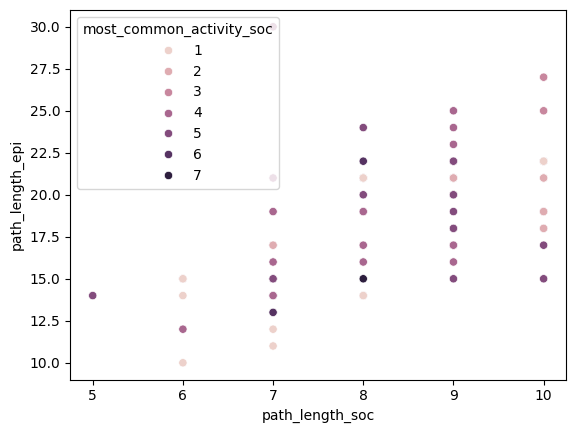

In [37]:
sns.scatterplot(x=distances_df["path_length_soc"], y=distances_df["path_length_epi"],hue=distances_df["most_common_activity_soc"])

<Axes: xlabel='days_to_common_ancestor_source_epi', ylabel='days_to_common_ancestor_dest_epi'>

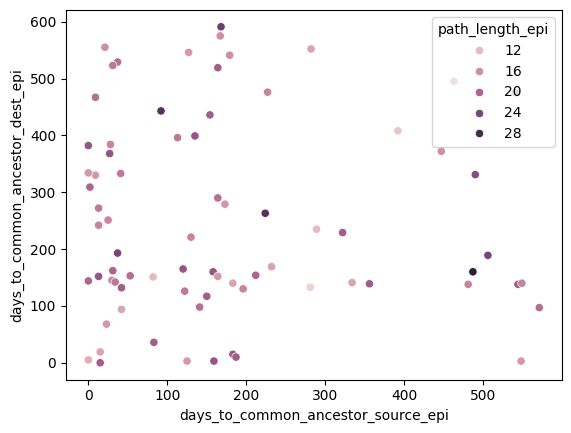

In [38]:
distances_df['days_to_common_ancestor_source_epi'] = distances_df['infect_tick_source_epi'] - distances_df['min_tick_epi']
distances_df['days_to_common_ancestor_dest_epi'] = distances_df['infect_tick_dest_epi'] - distances_df['min_tick_epi']

sns.scatterplot(x = distances_df['days_to_common_ancestor_source_epi'], y=distances_df['days_to_common_ancestor_dest_epi'], hue=distances_df['path_length_epi'])